In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
from sklearn.tree import DecisionTreeClassifier,plot_tree

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)

In [2]:
colonnes_a_supprimer = ['CODTYPPRS', 'CRTOD_CMT_PRO_IND_0209','INDPARDCD','CRTOP_AG_IND_0038', 'CRTOP_IND_0038', 'CRTOU_CCT_PRO_IND_0209', 'DATCREENT', 'DATRLNORG', 'RATIO1', 'RATIO3', 'TOP_PRO_ACTIF', 'IND_ACTIF', 'IND_PER_PM', 'CODCMNIEE', 'CODPAY_NAISSANCE', 'CODPAY_NATIONALITE', 'CODPAY_RESIDENCE', 'CODSEXPRS', 'secteur_activite', 'secteur_activite_bis' ]
samples = samples = pd.read_excel('../data/samples.xlsx', sheet_name=None)
train = samples[list(samples.keys())[0]]
train = train.drop(columns=colonnes_a_supprimer)
test = samples[list(samples.keys())[1]]
test = test.drop(columns=colonnes_a_supprimer)
oot = samples[list(samples.keys())[2]]
oot = oot.drop(columns=colonnes_a_supprimer)
sample = pd.concat([train, test, oot], ignore_index=True)
sample['datdelhis'] = sample['datdelhis'] % 100
sample['datdelhis'] = sample['datdelhis'].astype(str)

In [41]:
train=train[["DDefaut_NDB",
    "CRTOC_IND_0015",
    "CRTOC_AG_NBJCRE_2T_IND_0009",
    "CRTOC_AG_LIGDEB_2T_IND_0015",
    "CRTOC_AG_MVTAFF_2T_IND_0010", 
    "CRTOC_MOY_MVTAFF_IND_0010"]]
train.to_excel('../data/tr.xlsx', index=False)


In [42]:
test=test[["DDefaut_NDB",
    "CRTOC_IND_0015",
    "CRTOC_AG_NBJCRE_2T_IND_0009",
    "CRTOC_AG_LIGDEB_2T_IND_0015",
    "CRTOC_AG_MVTAFF_2T_IND_0010", 
    "CRTOC_MOY_MVTAFF_IND_0010"]]
test.to_excel('../data/te.xlsx', index=False)

In [43]:
oot=oot[["DDefaut_NDB",
    "CRTOC_IND_0015",
    "CRTOC_AG_NBJCRE_2T_IND_0009",
    "CRTOC_AG_LIGDEB_2T_IND_0015",
    "CRTOC_AG_MVTAFF_2T_IND_0010", 
    "CRTOC_MOY_MVTAFF_IND_0010"]]
oot.to_excel('../data/o.xlsx', index=False)

In [32]:
def discretize_feature_based_on_tree(feature, n_bins, custom_thresholds=None):
    """
    Discrétise une caractéristique (feature) basée sur un classifieur d'arbre de décision,
    avec possibilité de réajuster les seuils automatiquement ou manuellement.

    Paramètres :
    - feature : str, le nom de la caractéristique à discrétiser.
    - n_bins : int, le nombre de feuilles dans l'arbre de décision.
    - custom_thresholds : list (optionnelle), liste de seuils définis manuellement.

    Retourne :
    - Le nom de la nouvelle colonne discrétisée.
    """
    target = 'DDefaut_NDB'
    
    # Extraire les données de la caractéristique et de la cible
    X = train[[feature]].values
    y = train[target].values

    # Initialiser le classifieur d'arbre de décision
    clf = DecisionTreeClassifier(
        max_leaf_nodes=n_bins,
        random_state=42,
        min_samples_split=0.05,
    )
    
    # Entraîner le modèle
    clf.fit(X, y)

    # Obtenir les seuils triés ou utiliser les seuils personnalisés
    if custom_thresholds:
        thresholds = np.array(custom_thresholds)
    else:
        thresholds = np.sort(clf.tree_.threshold[clf.tree_.threshold != -2])

    def assign_class(value):
        """
        Attribue une classe à une valeur en fonction des seuils définis.
        """
        for i, threshold in enumerate(thresholds):
            if value <= threshold:
                return i + 1
        return len(thresholds) + 1

    # Appliquer la discrétisation
    discretized_column_train = train[feature].apply(assign_class)
    discretized_column_name = f"{feature}_discretized"
    train[discretized_column_name] = discretized_column_train

    discretized_column_sample = sample[feature].apply(assign_class)
    sample[discretized_column_name] = discretized_column_sample

    # Afficher les seuils et l'arbre pour vérification
    print(f"Seuils de coupure pour '{feature}' : {thresholds}")

    # Affichage de l'arbre
    plt.figure(figsize=(20, 10))
    plot_tree(clf, 
          feature_names=[feature], 
          filled=False, 
          rounded=True, 
          fontsize=12)
    plt.show()

    return discretized_column_name


Seuils de coupure pour 'CRTOC_IND_0015' : [ 3.5 27.5]


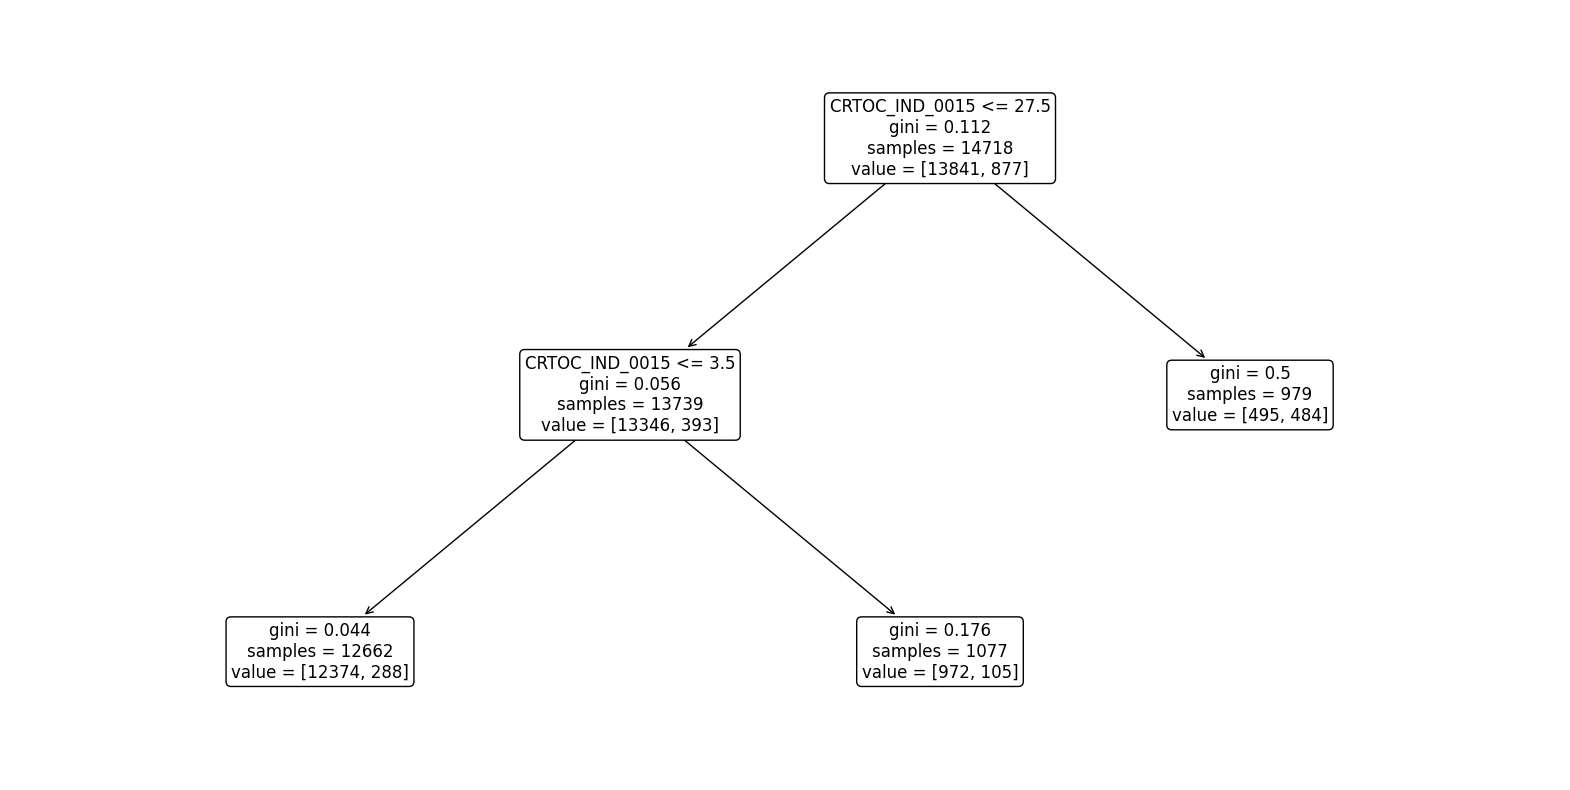

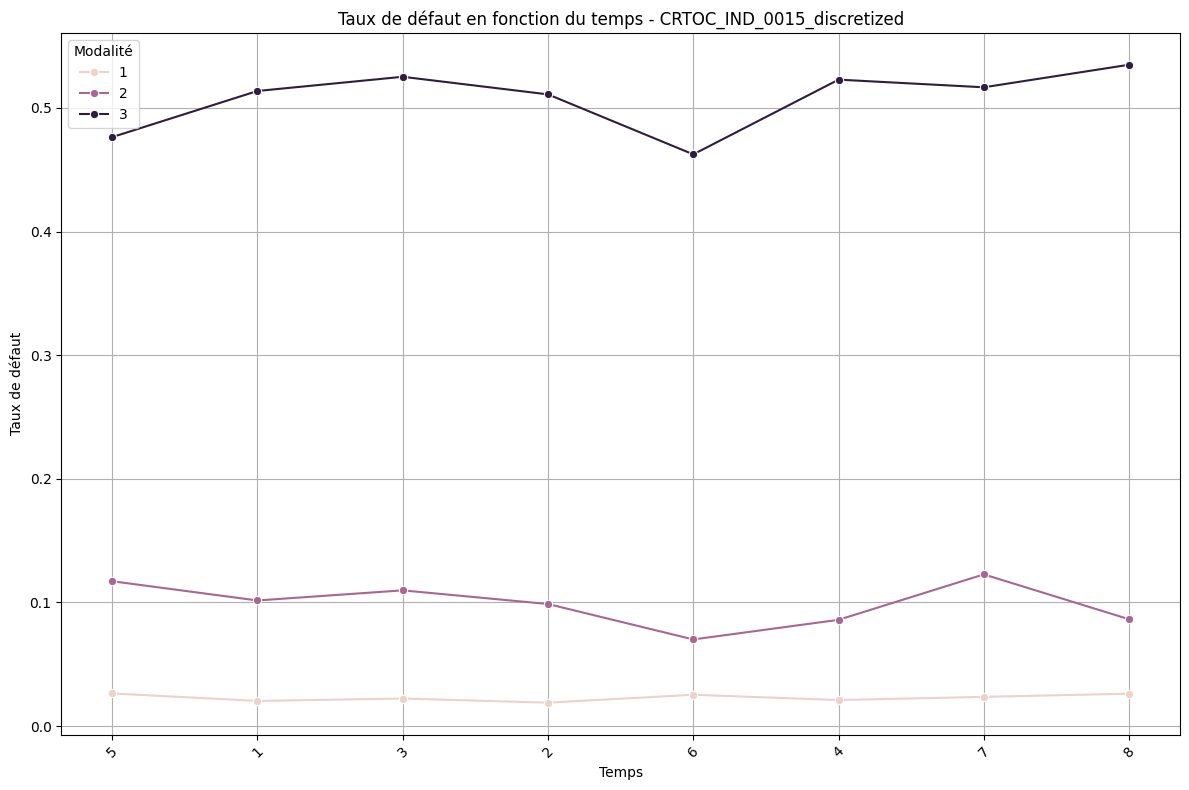

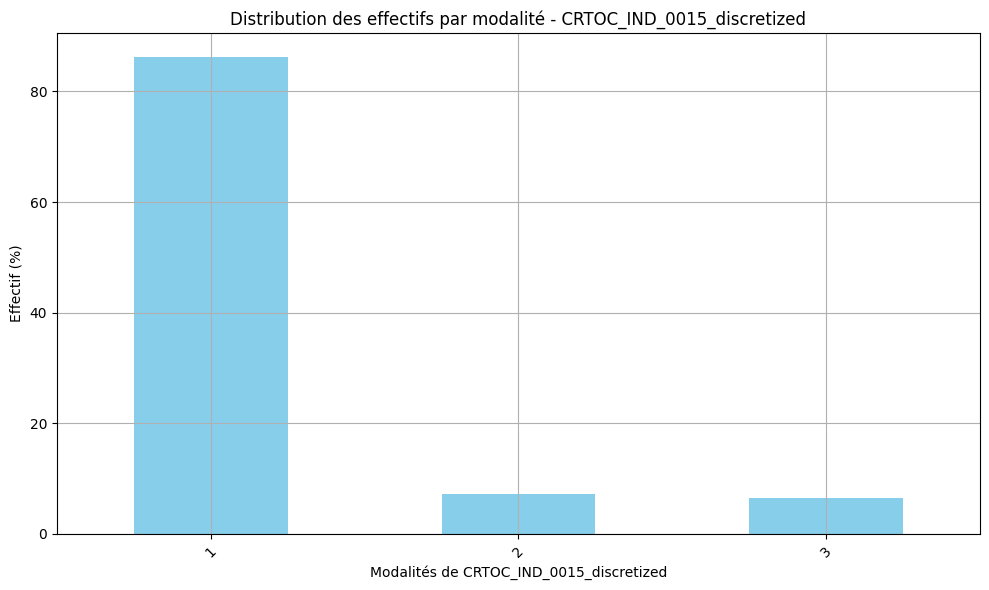

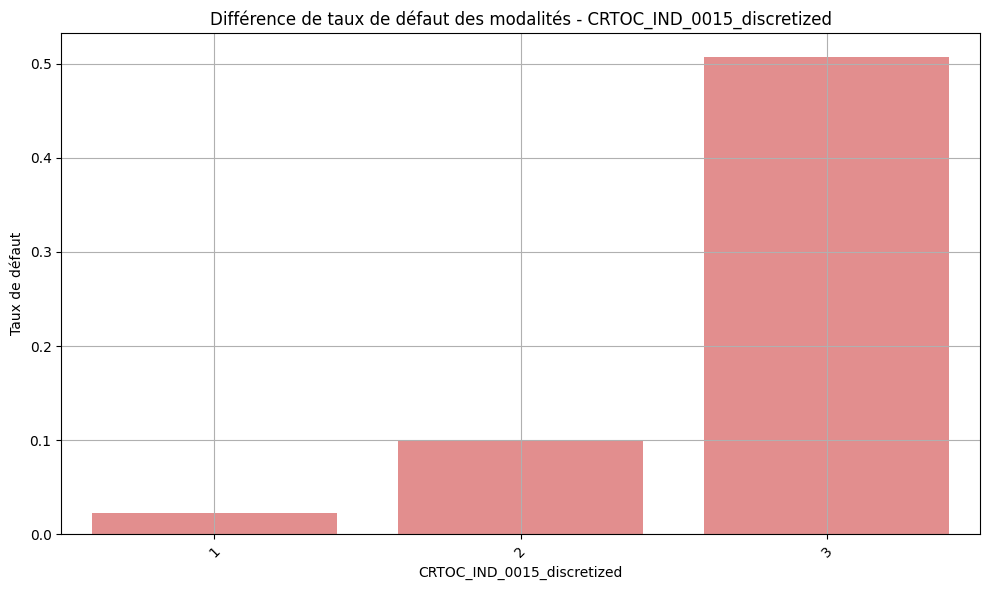

Seuils de coupure pour 'ratio_jours_debiteurs' : [0.14776674]


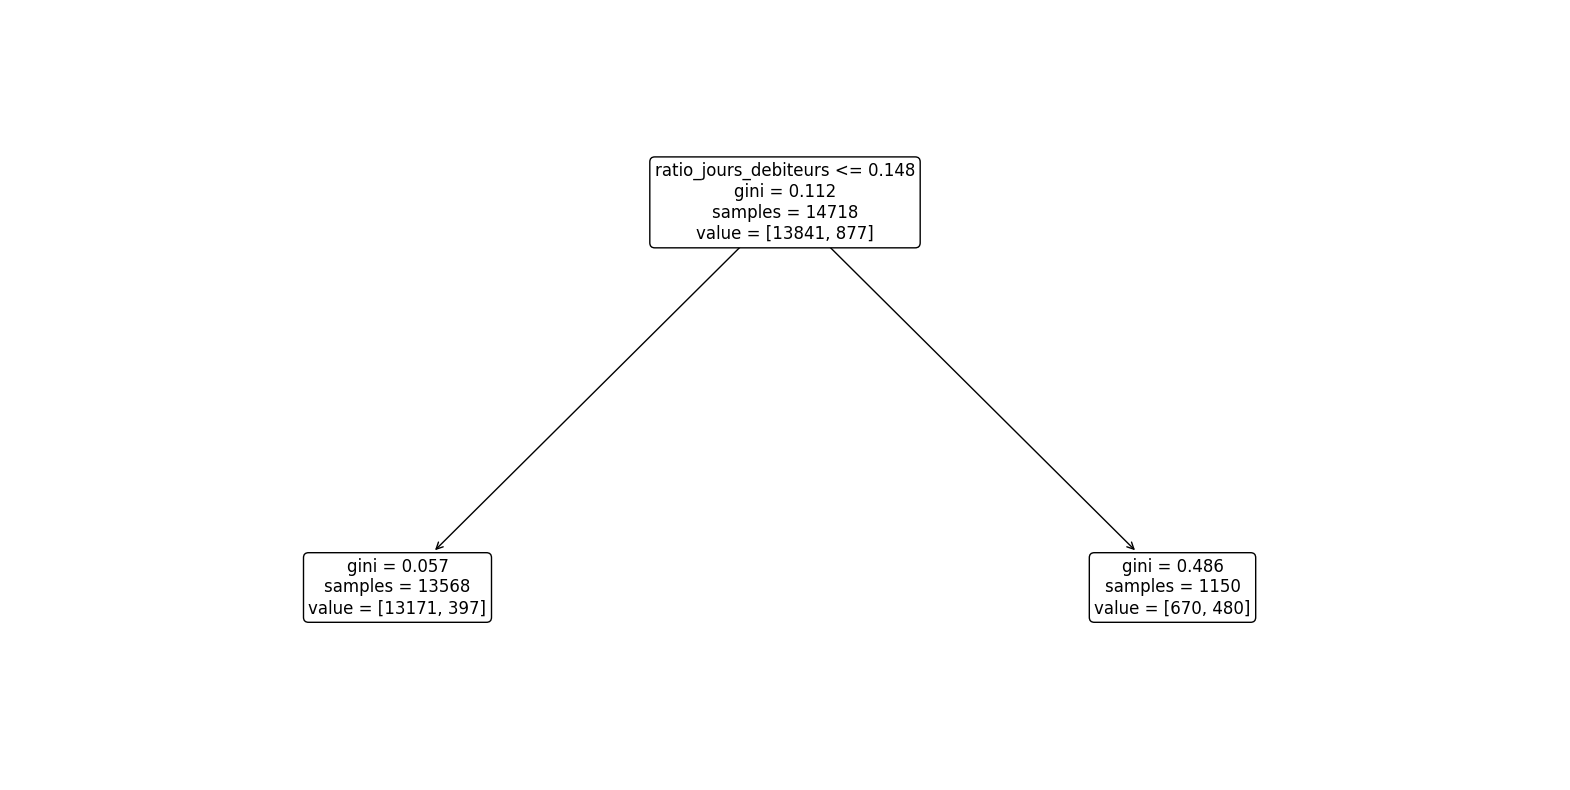

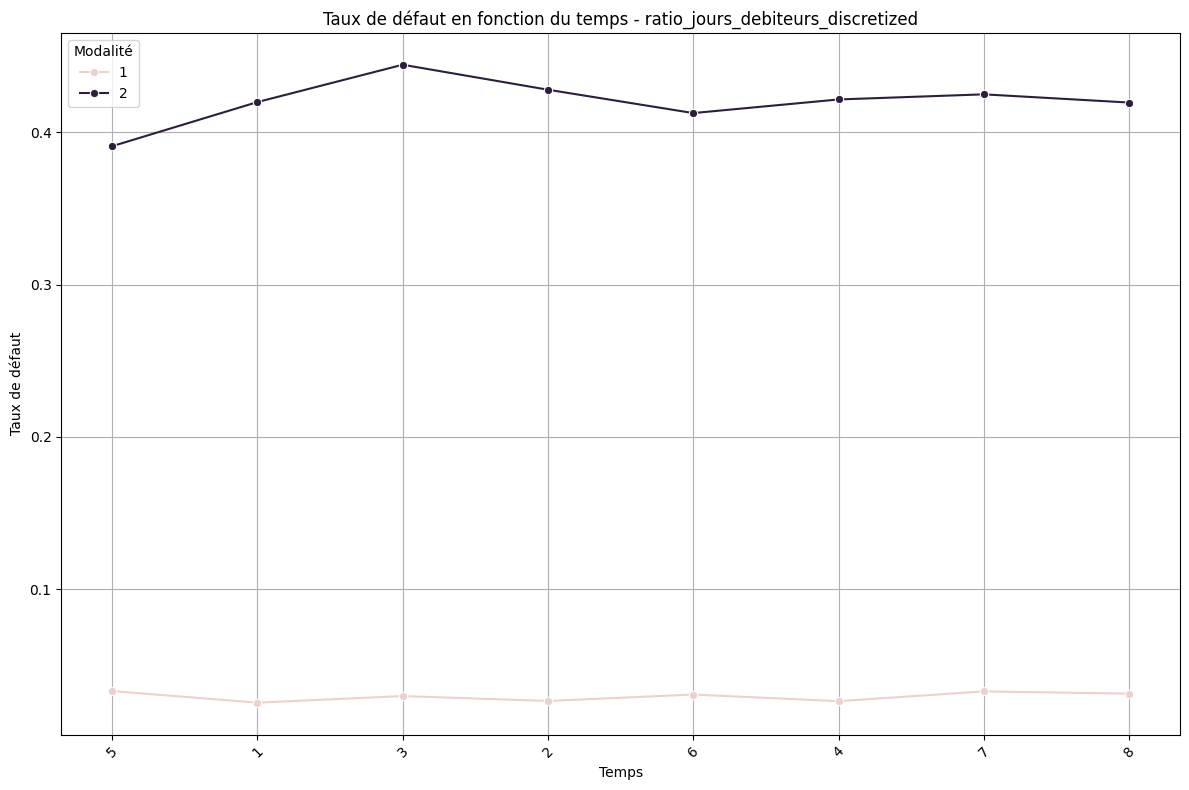

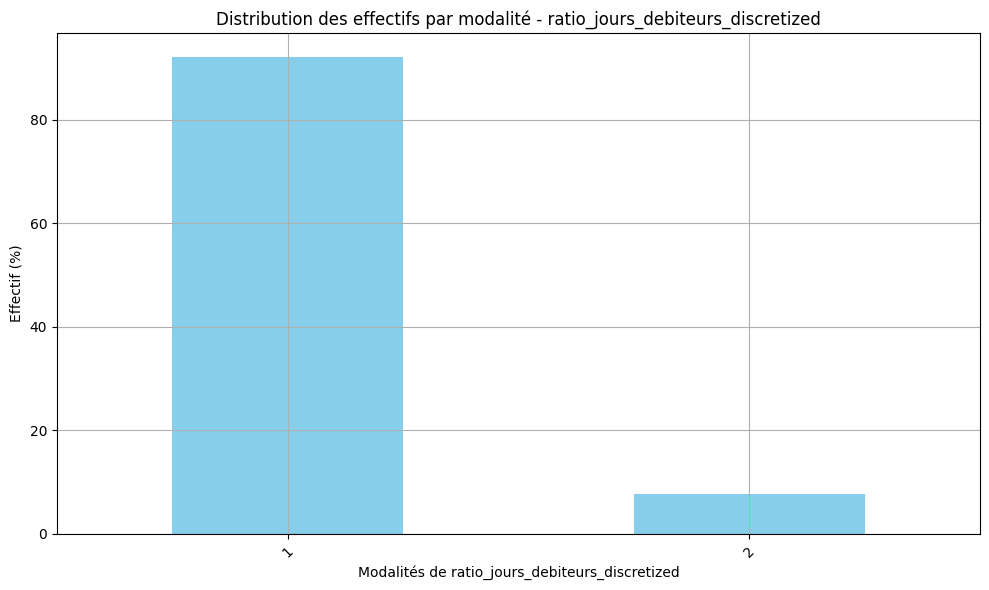

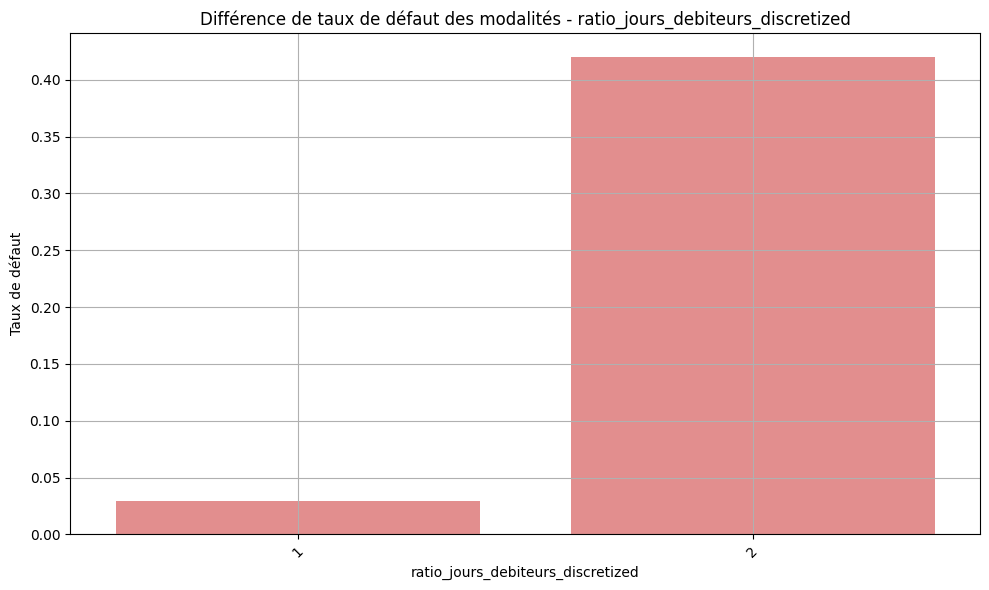

Seuils de coupure pour 'CRTOC_AG_LIGDEB_2T_IND_0015' : [-403533.5]


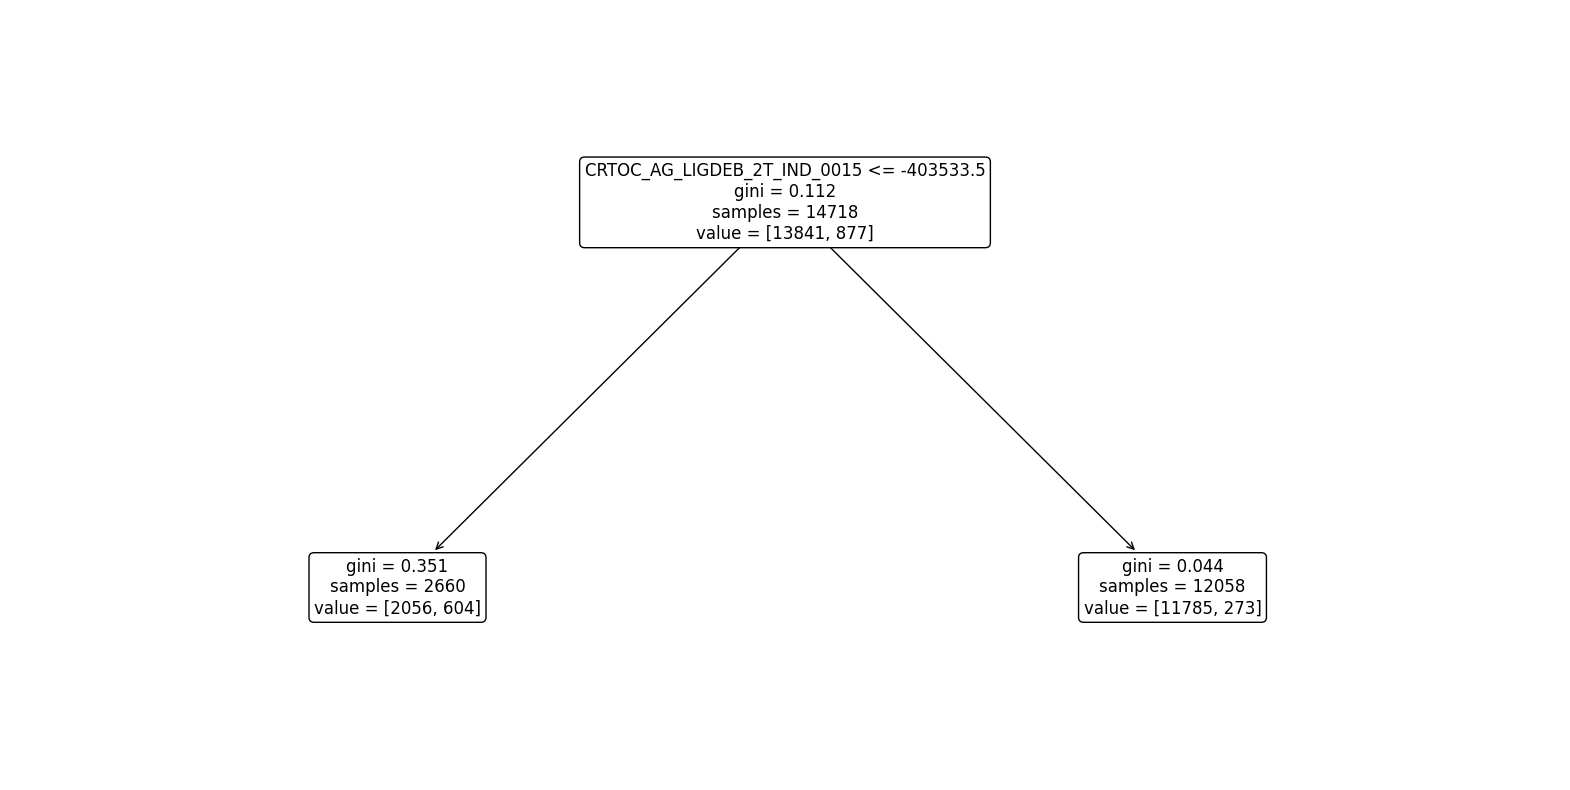

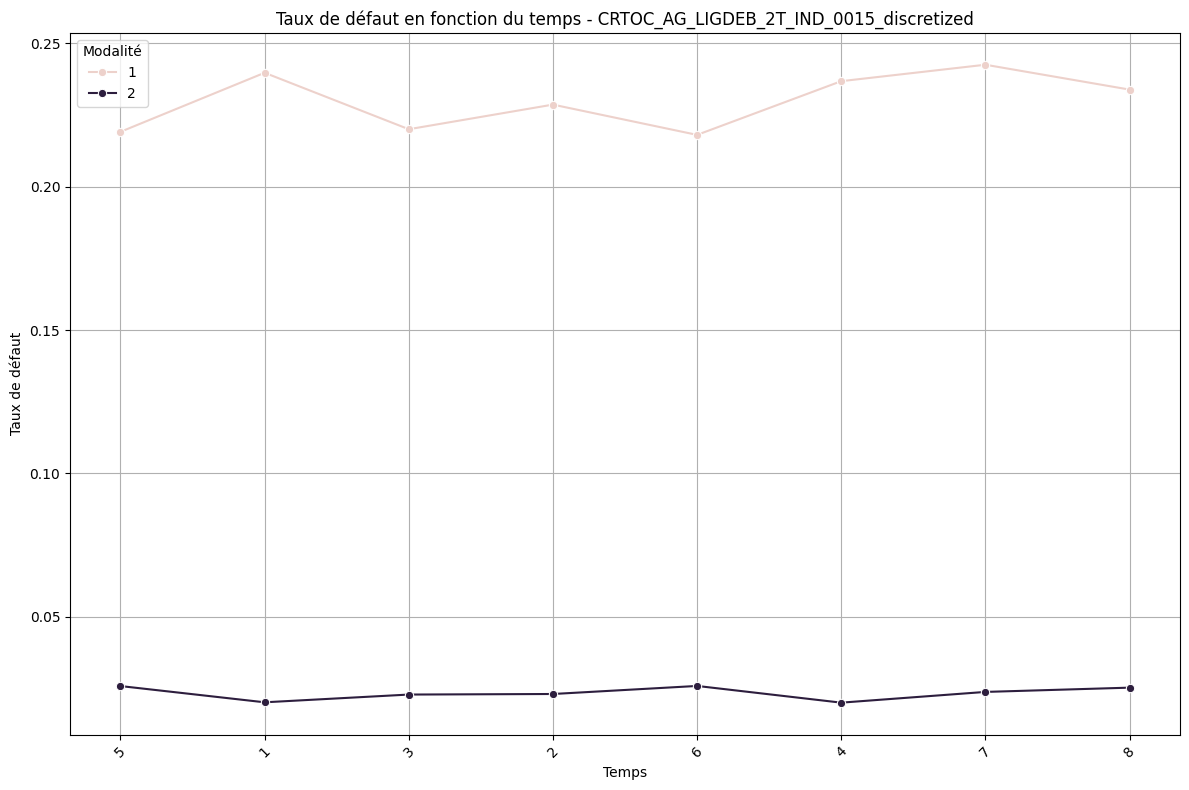

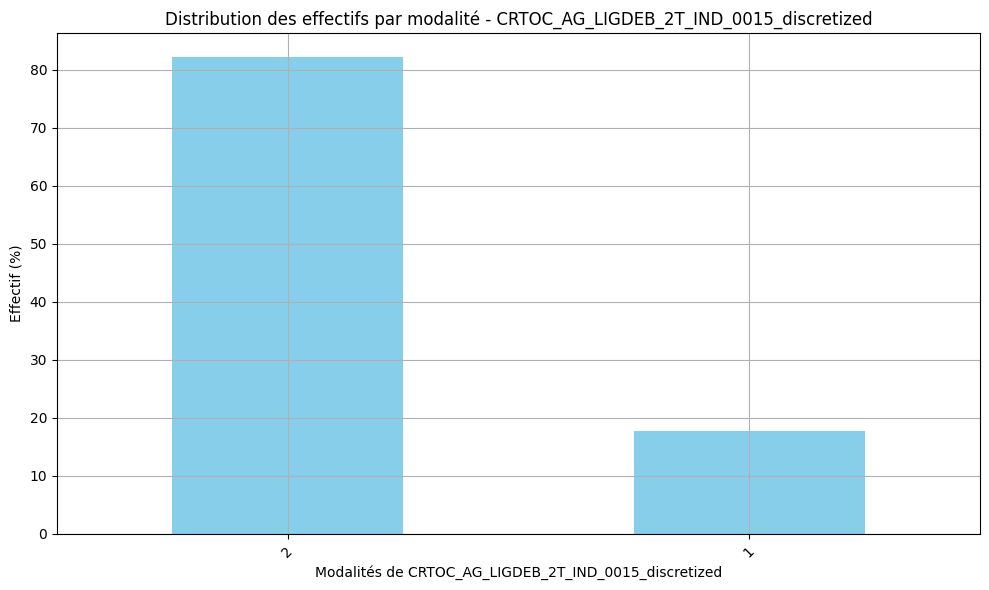

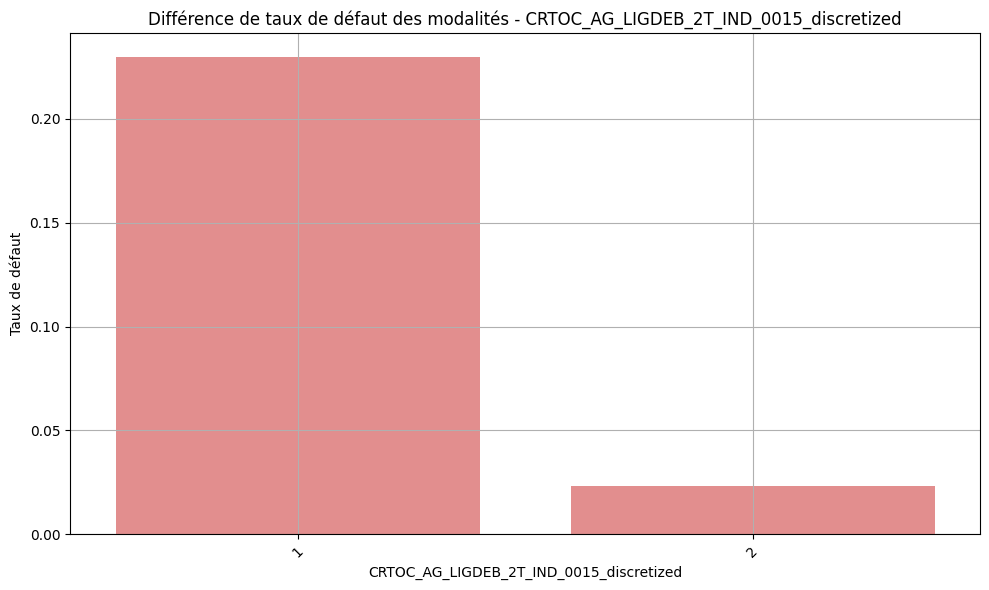

Seuils de coupure pour 'CRTOC_IND_0164' : [-3950.]


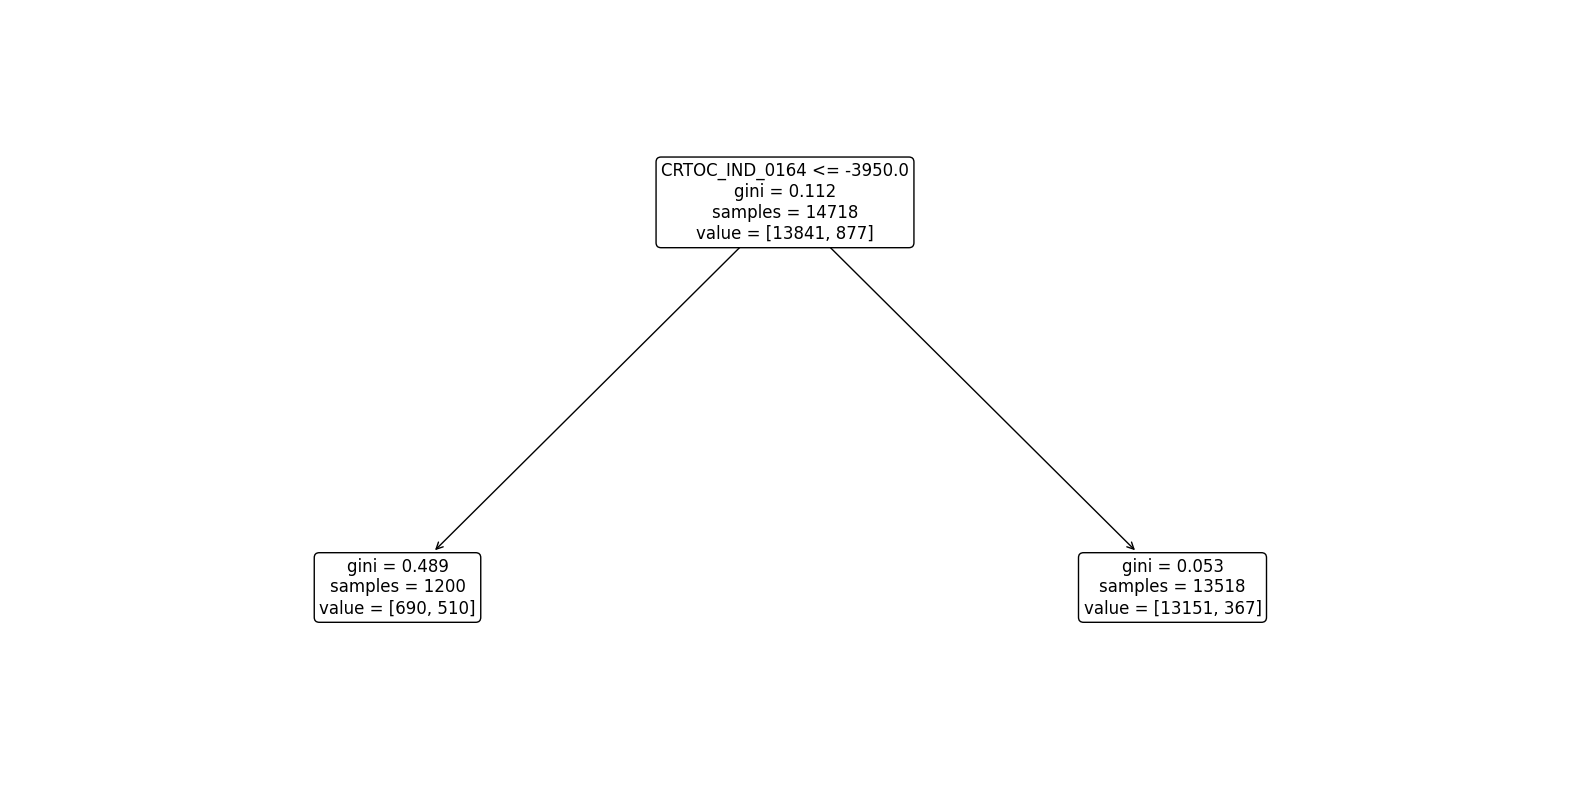

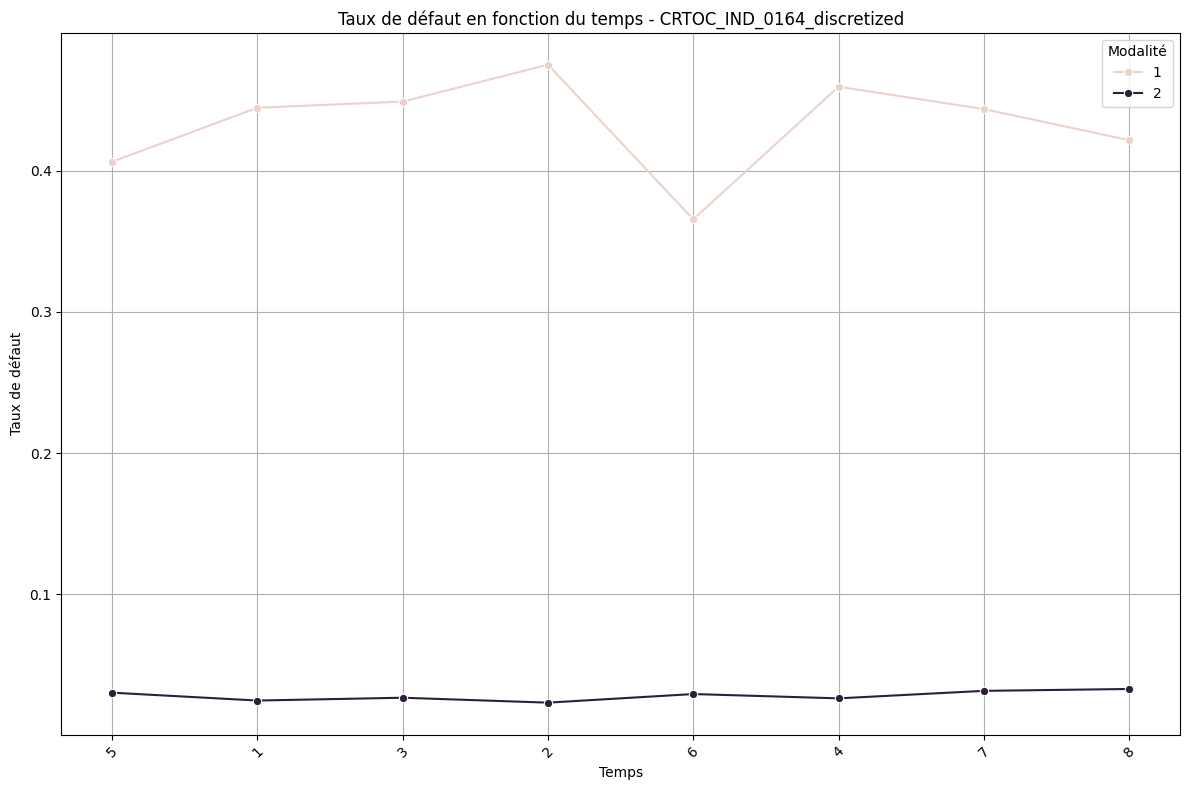

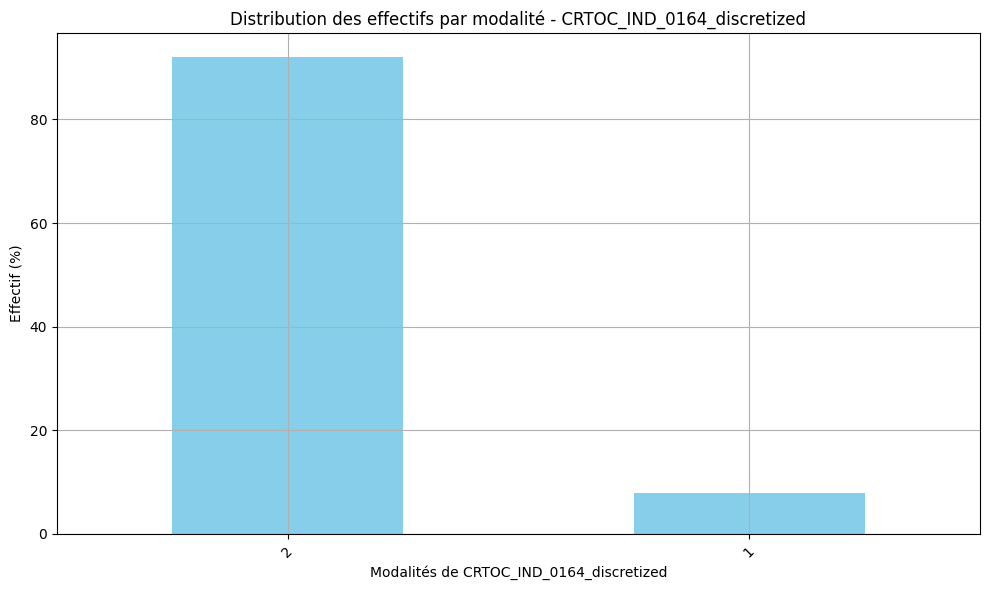

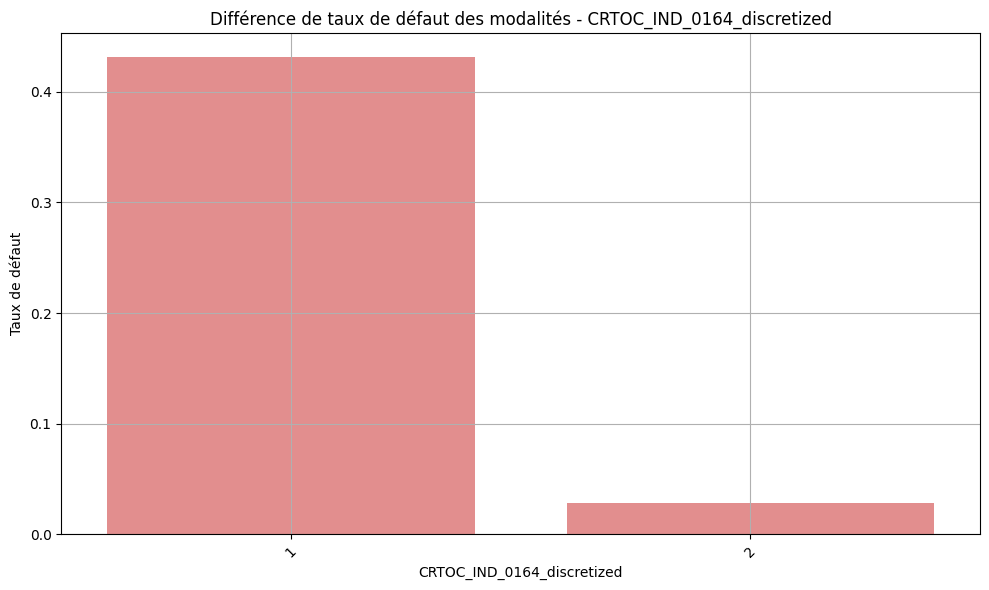

Seuils de coupure pour 'CRTOC_AG_NBJCRE_2T_IND_0009' : [11.5]


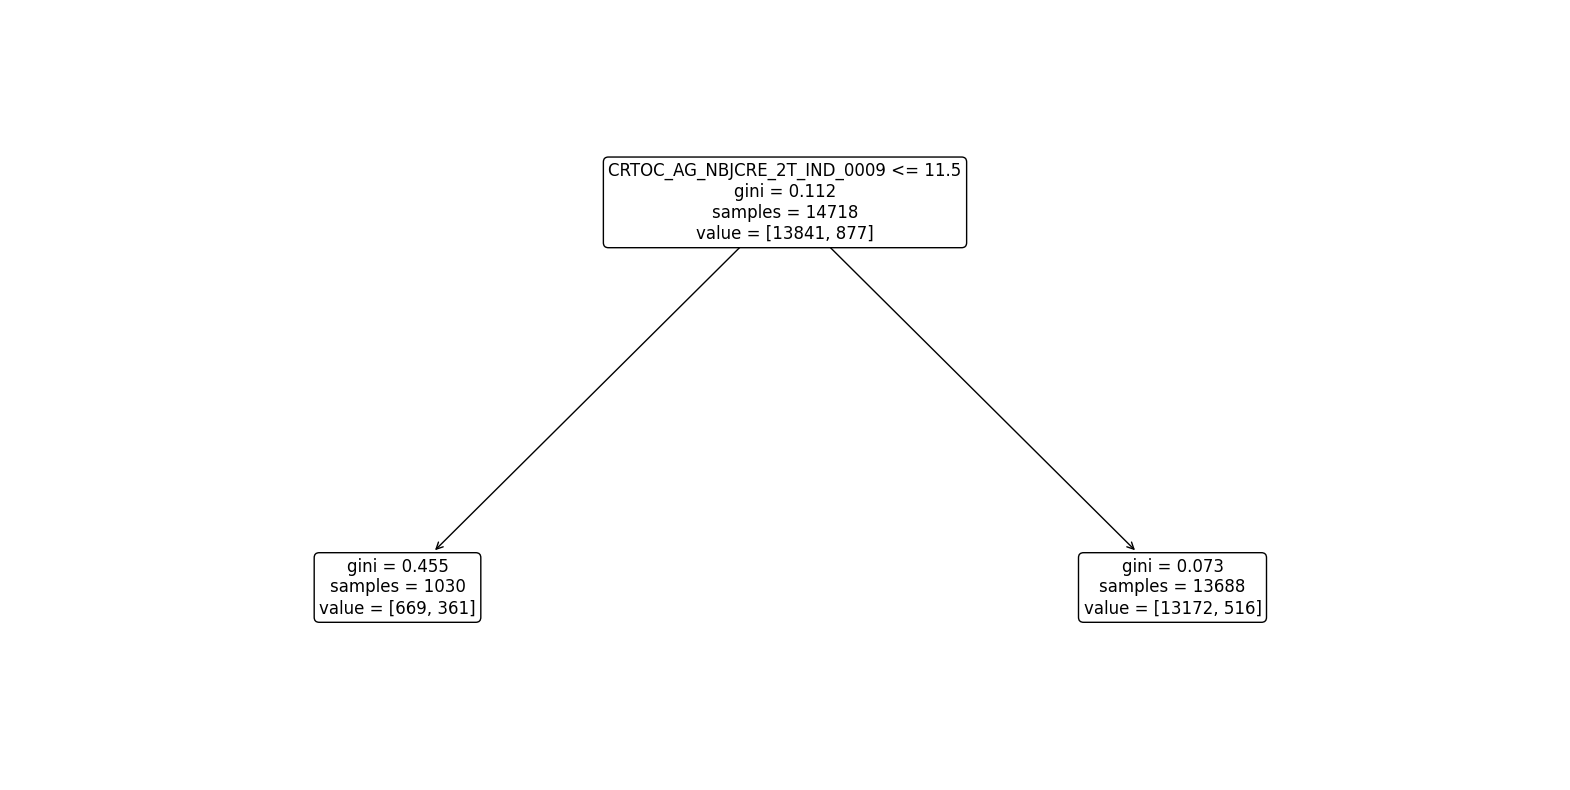

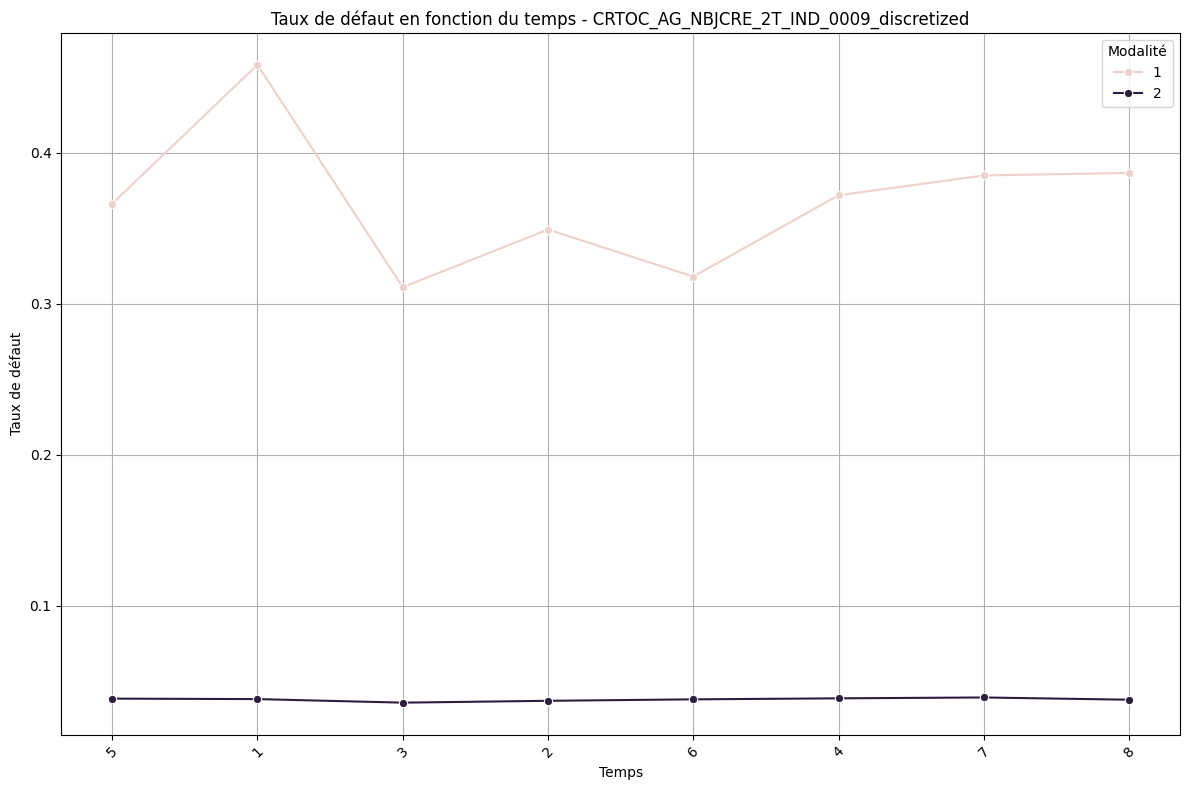

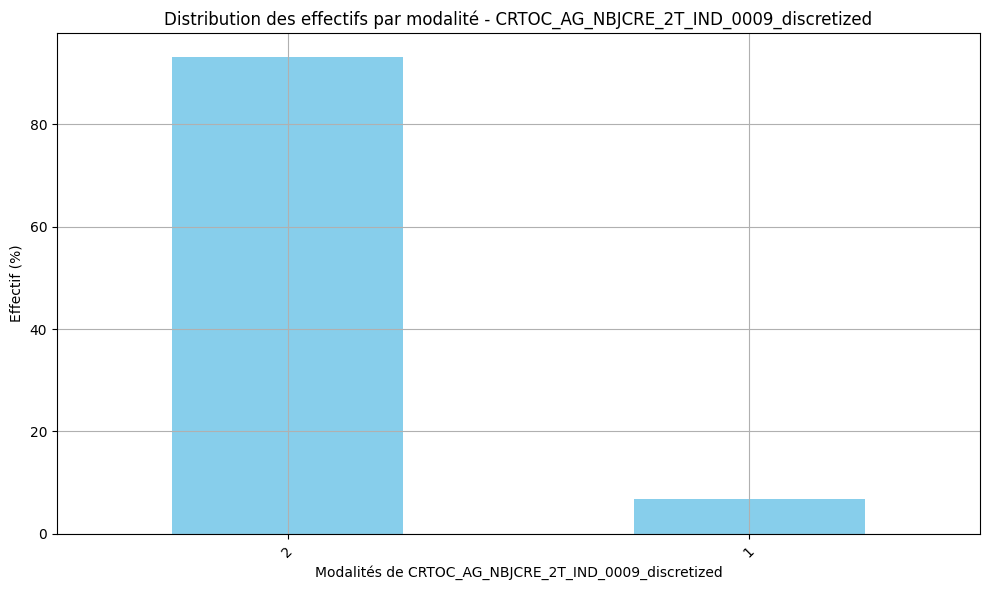

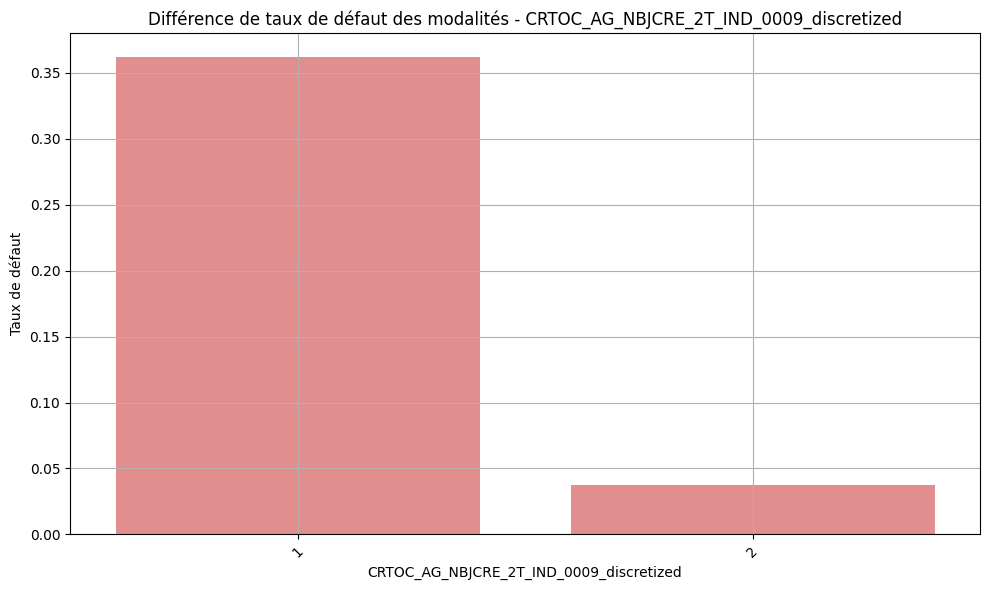

Seuils de coupure pour 'CRTOC_AG_MVTAFF_2T_IND_0010' : [  14156. 1811925.]


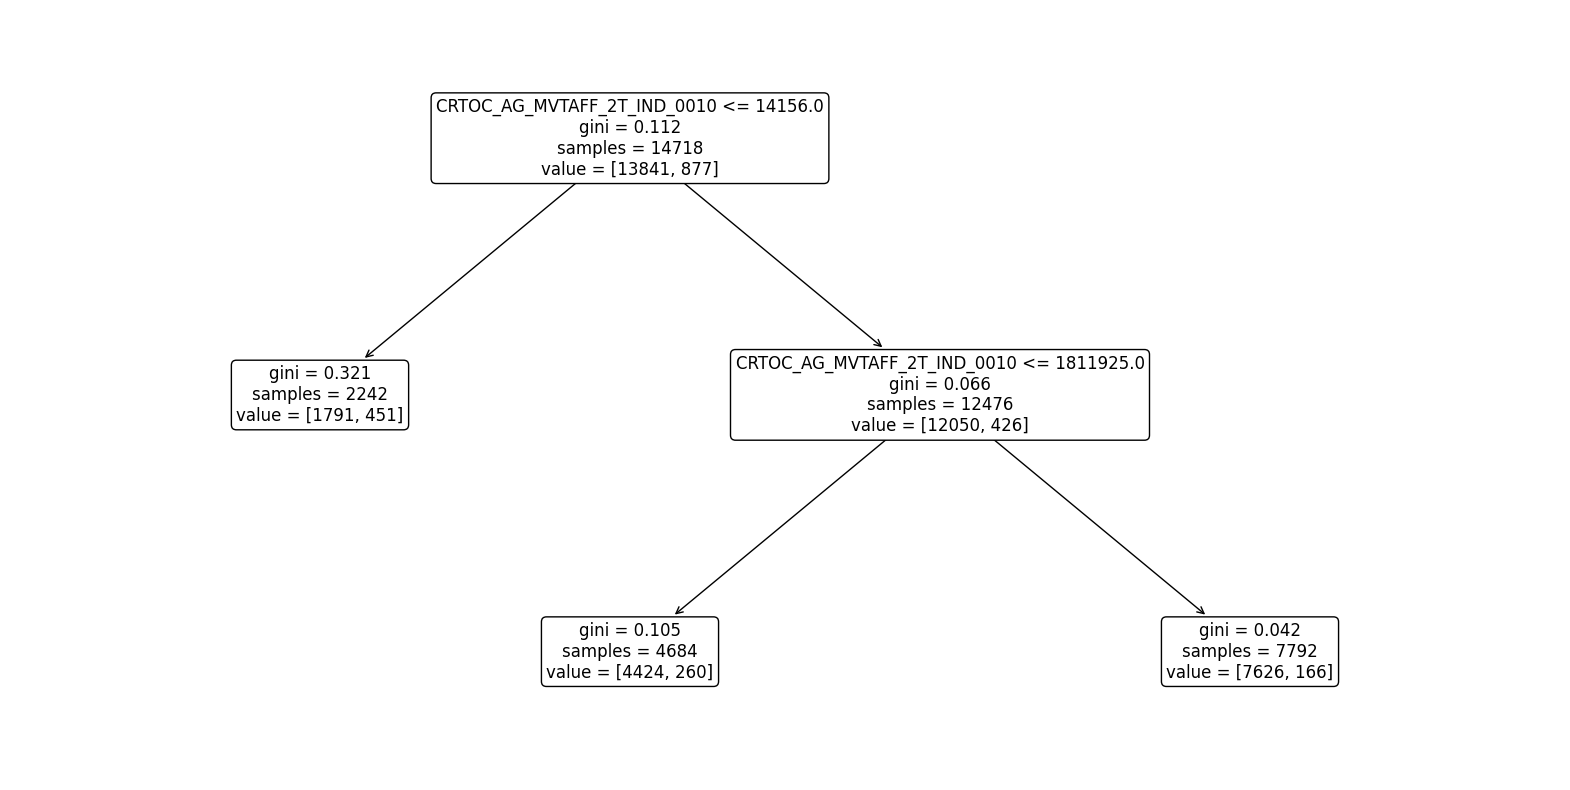

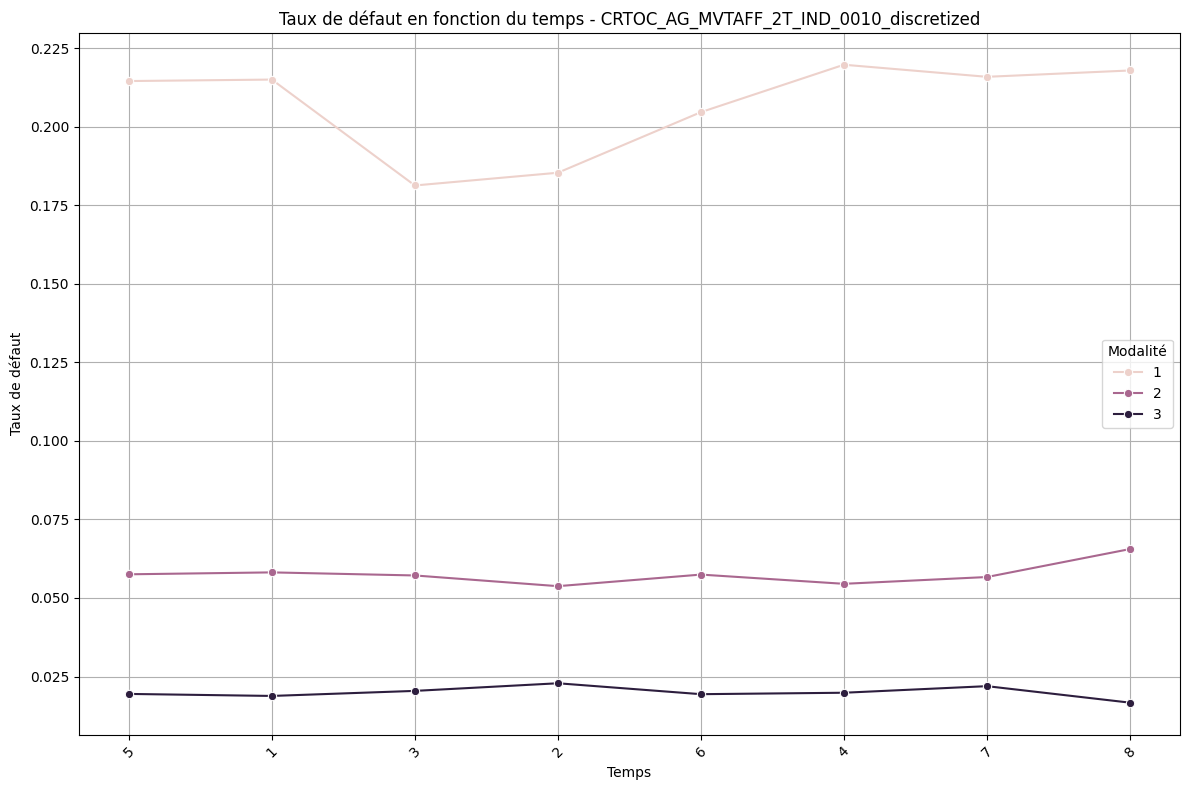

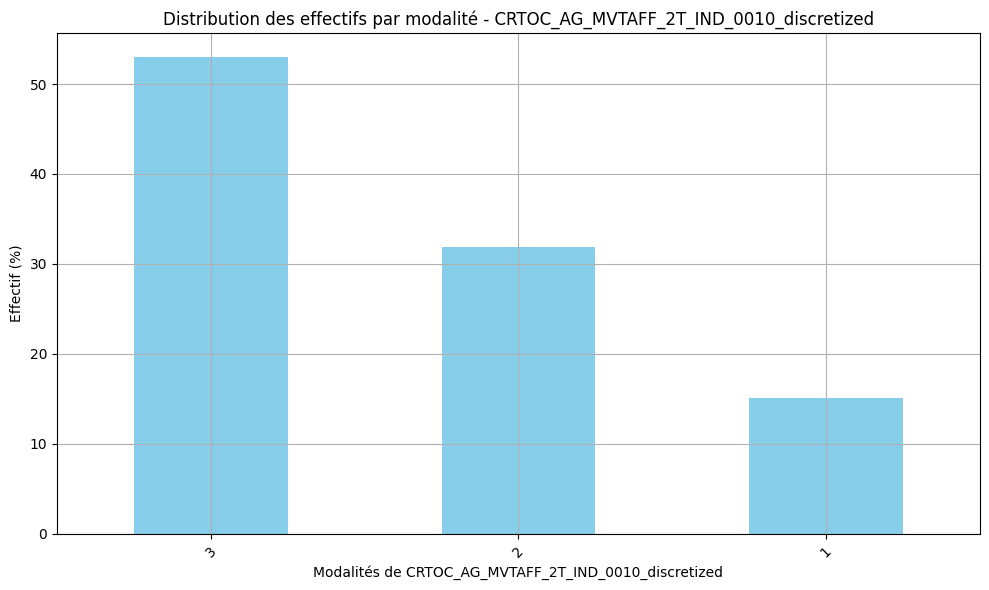

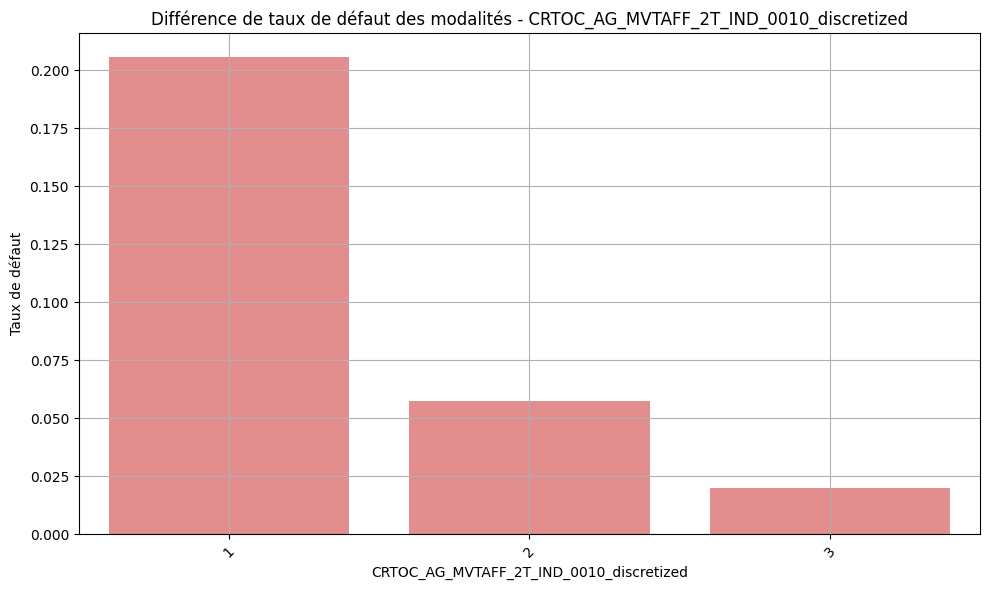

Seuils de coupure pour 'CRTOC_MOY_MVTAFF_IND_0010' : [4.950000e+01 1.527275e+05]


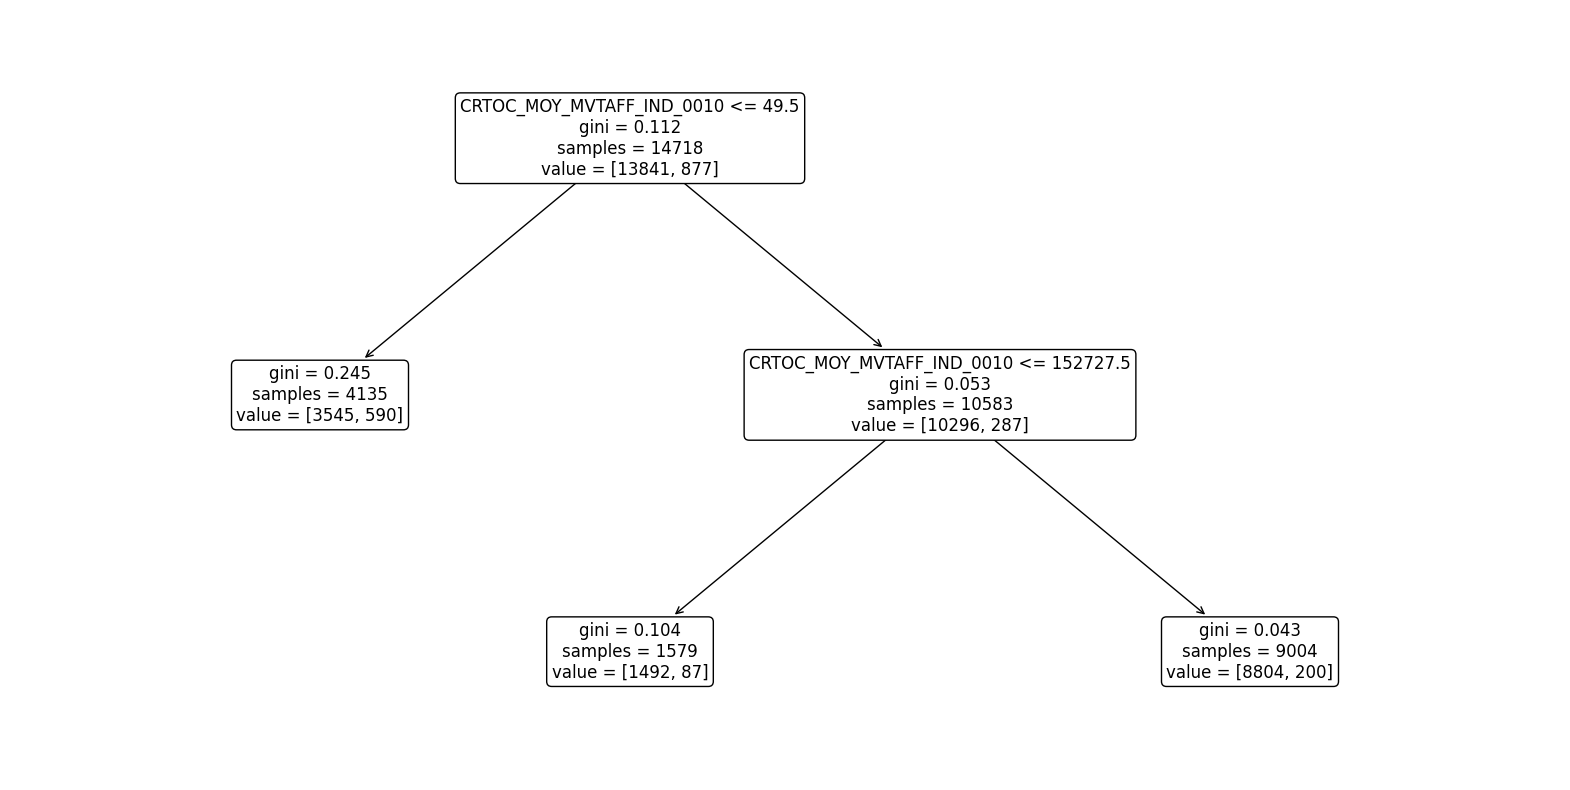

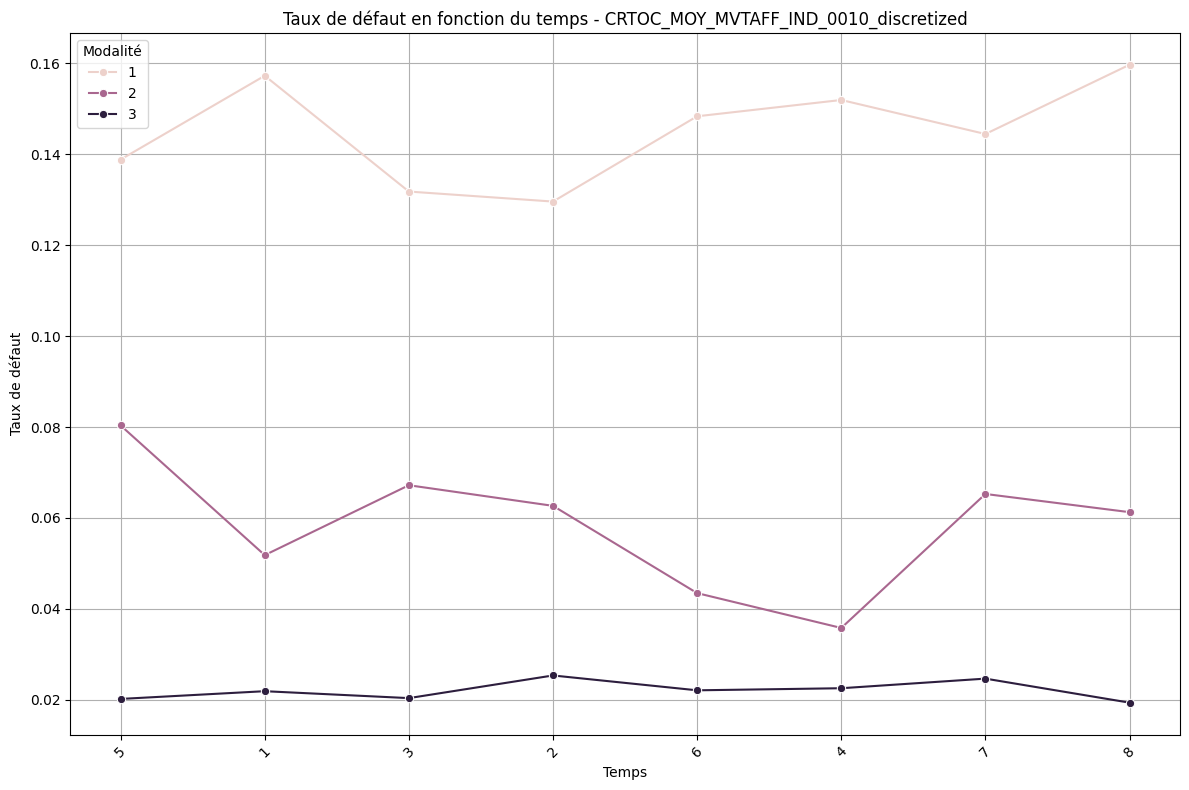

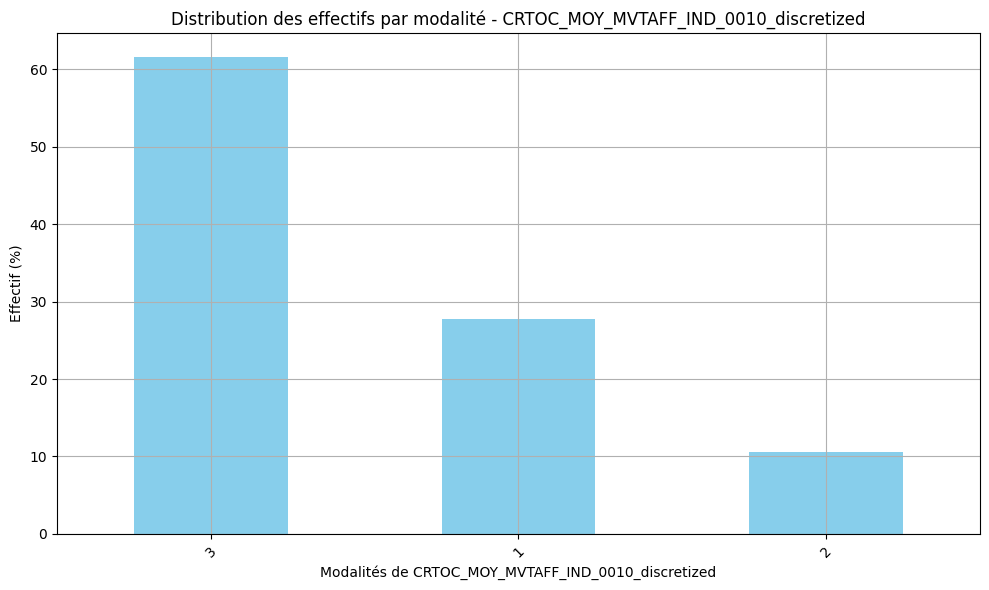

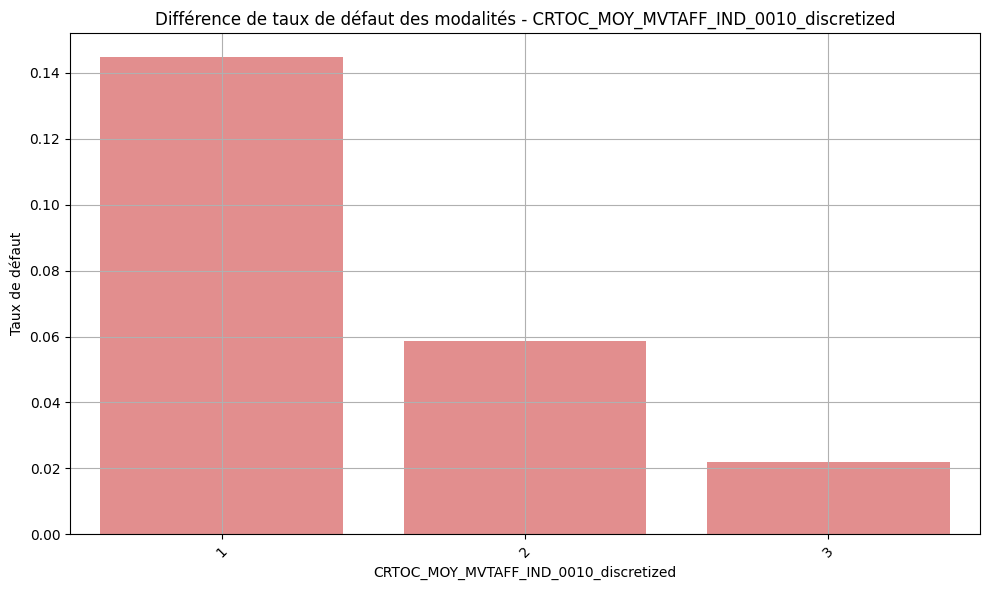

In [30]:
# Liste des colonnes quantitatives à discrétiser après les tests de Wallis et Pearson
quantitative_cols_after_wallis_pearson = [
    'CRTOC_IND_0015', 
    'ratio_jours_debiteurs',
    'CRTOC_AG_LIGDEB_2T_IND_0015', 
    'CRTOC_IND_0164', 
    'CRTOC_AG_NBJCRE_2T_IND_0009', 
    'CRTOC_AG_MVTAFF_2T_IND_0010', 
    'CRTOC_MOY_MVTAFF_IND_0010'
]
# Liste des nombres de classes (bins) pour chaque colonne
n_bins_list = [3, 2, 2, 2, 2, 3, 3]

# Supposons que 'sample' soit un DataFrame chargé dans votre environnement.
# Assurez-vous que la fonction 'discretize_feature_based_on_tree' est bien définie.

for i in range(len(n_bins_list)):
    # Discrétiser la caractéristique en utilisant la méthode de l'arbre
    discretized_column_name = discretize_feature_based_on_tree(
        quantitative_cols_after_wallis_pearson[i], n_bins_list[i]
    )
    
    # Calculer le taux de défaut moyen pour chaque classe discrétisée
    taux_defaut = sample.groupby(discretized_column_name)["DDefaut_NDB"].mean().sort_values()

    # Tracer l'évolution du taux de défaut dans le temps pour chaque groupe discrétisé
    plt.figure(figsize=(12, 8))
    sns.lineplot(
        x="datdelhis", 
        y="DDefaut_NDB", 
        hue=discretized_column_name, 
        data=sample, 
        ci=None, 
        marker='o'
    )
    plt.title(f"Taux de défaut en fonction du temps - {discretized_column_name}")
    plt.xlabel("Temps")
    plt.ylabel("Taux de défaut")
    plt.grid(True)
    plt.legend(title="Modalité")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Vérifier la stabilité des effectifs (au moins 5 % par modalité)
    modalites_count = sample[discretized_column_name].value_counts(normalize=True) * 100

    # Tracer la distribution des effectifs par modalité
    plt.figure(figsize=(10, 6))
    modalites_count.plot(kind="bar", color="skyblue")
    plt.title(f"Distribution des effectifs par modalité - {discretized_column_name}")
    plt.xlabel(f"Modalités de {discretized_column_name}")
    plt.ylabel("Effectif (%)")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Tracer la différence de taux de défaut entre modalités pour vérifier la séparation
    plt.figure(figsize=(10, 6))
    sns.barplot(x=taux_defaut.index, y=taux_defaut.values, color="lightcoral")
    plt.title(f"Différence de taux de défaut des modalités - {discretized_column_name}")
    plt.xlabel(f"{discretized_column_name}")
    plt.ylabel("Taux de défaut")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Seuils de coupure pour 'ratio_jours_debiteurs' : [0.15]


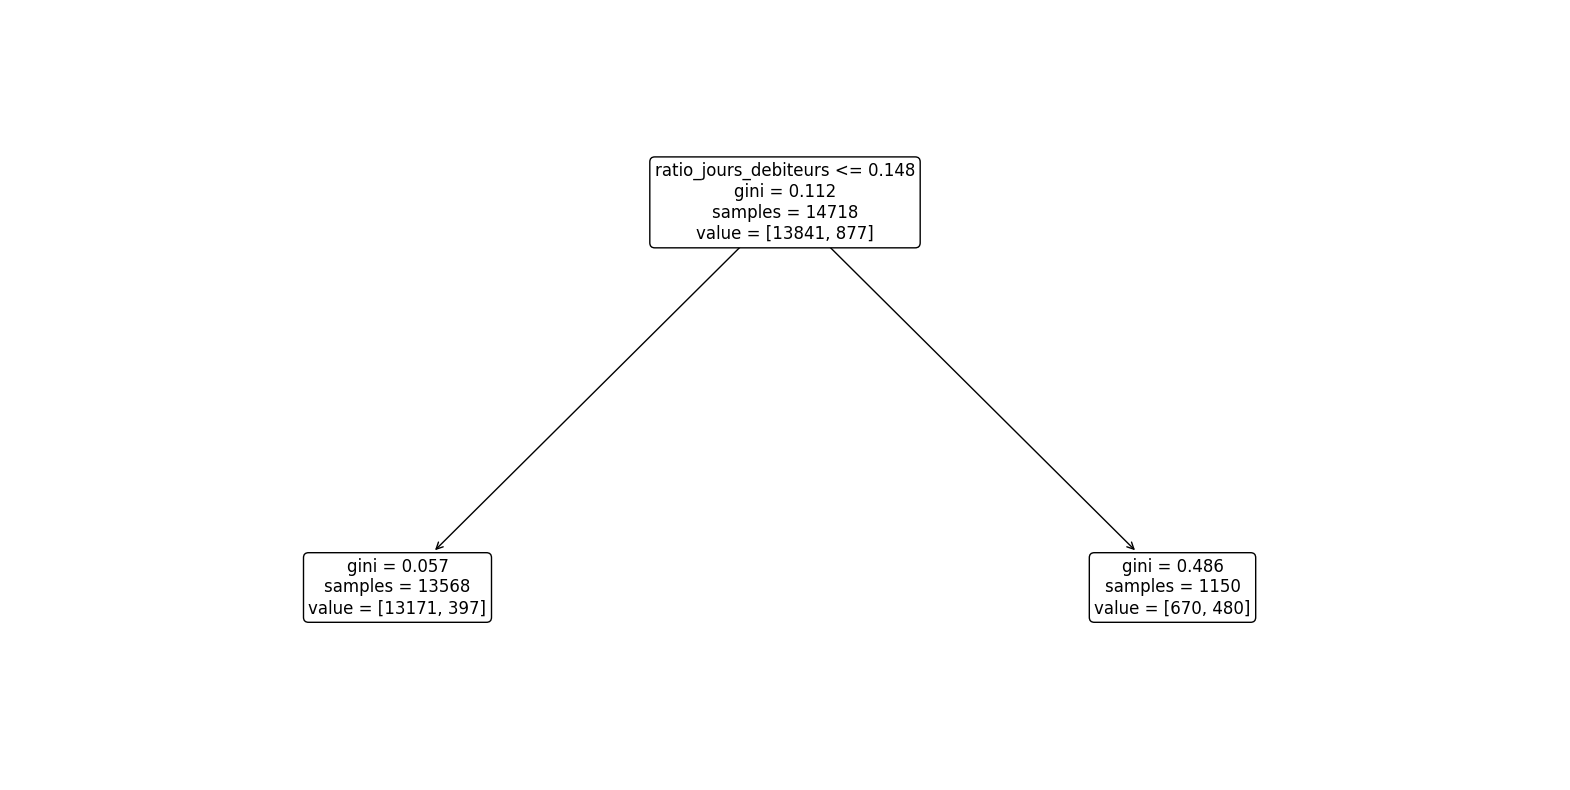

Seuils de coupure pour 'CRTOC_AG_MVTAFF_2T_IND_0010' : [  14200 1812000]


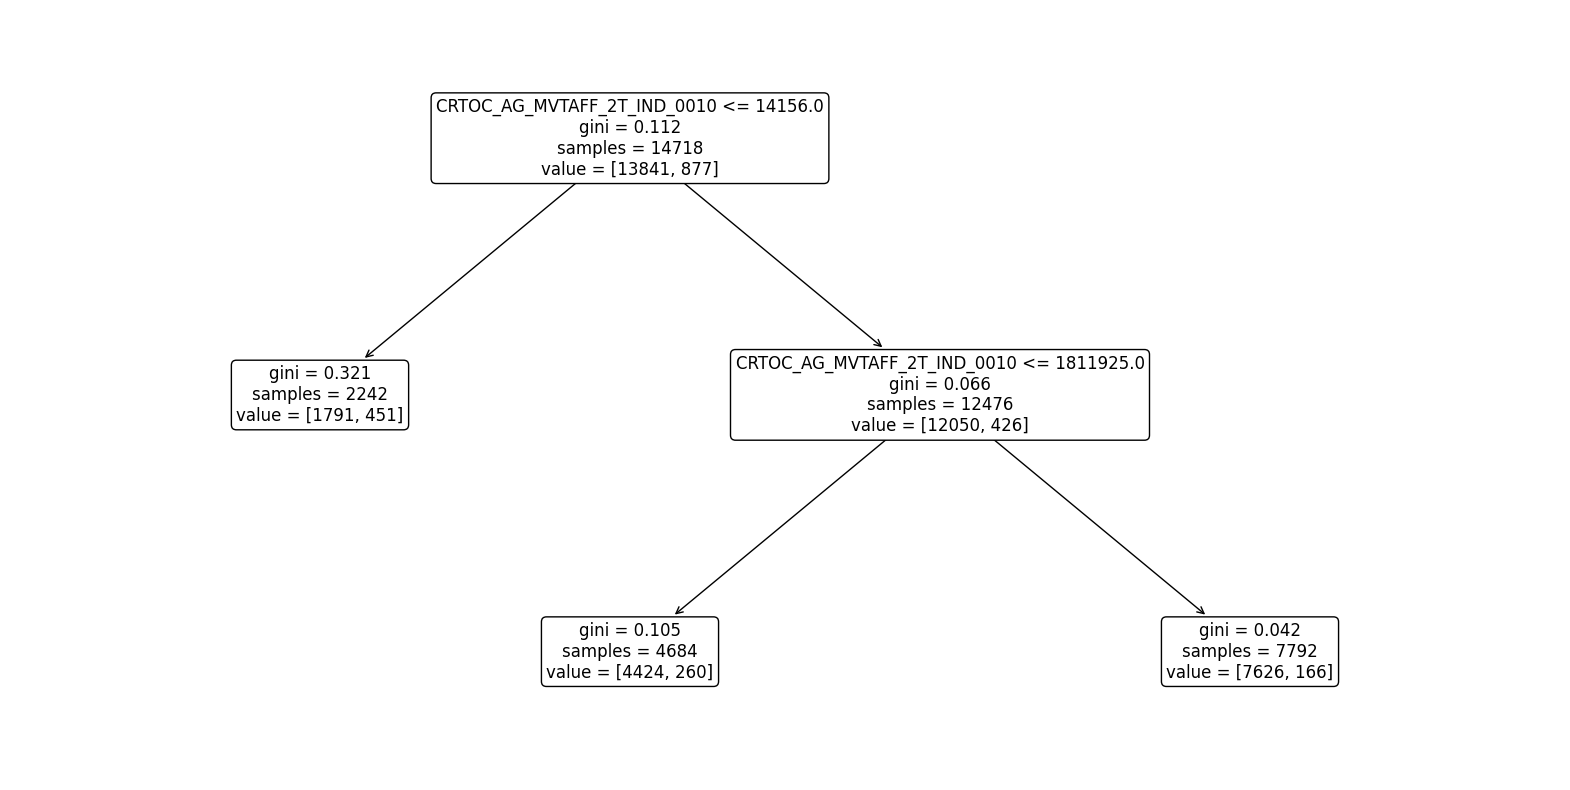

Seuils de coupure pour 'CRTOC_AG_MVTAFF_2T_IND_0010' : [4.950e+01 1.527e+05]


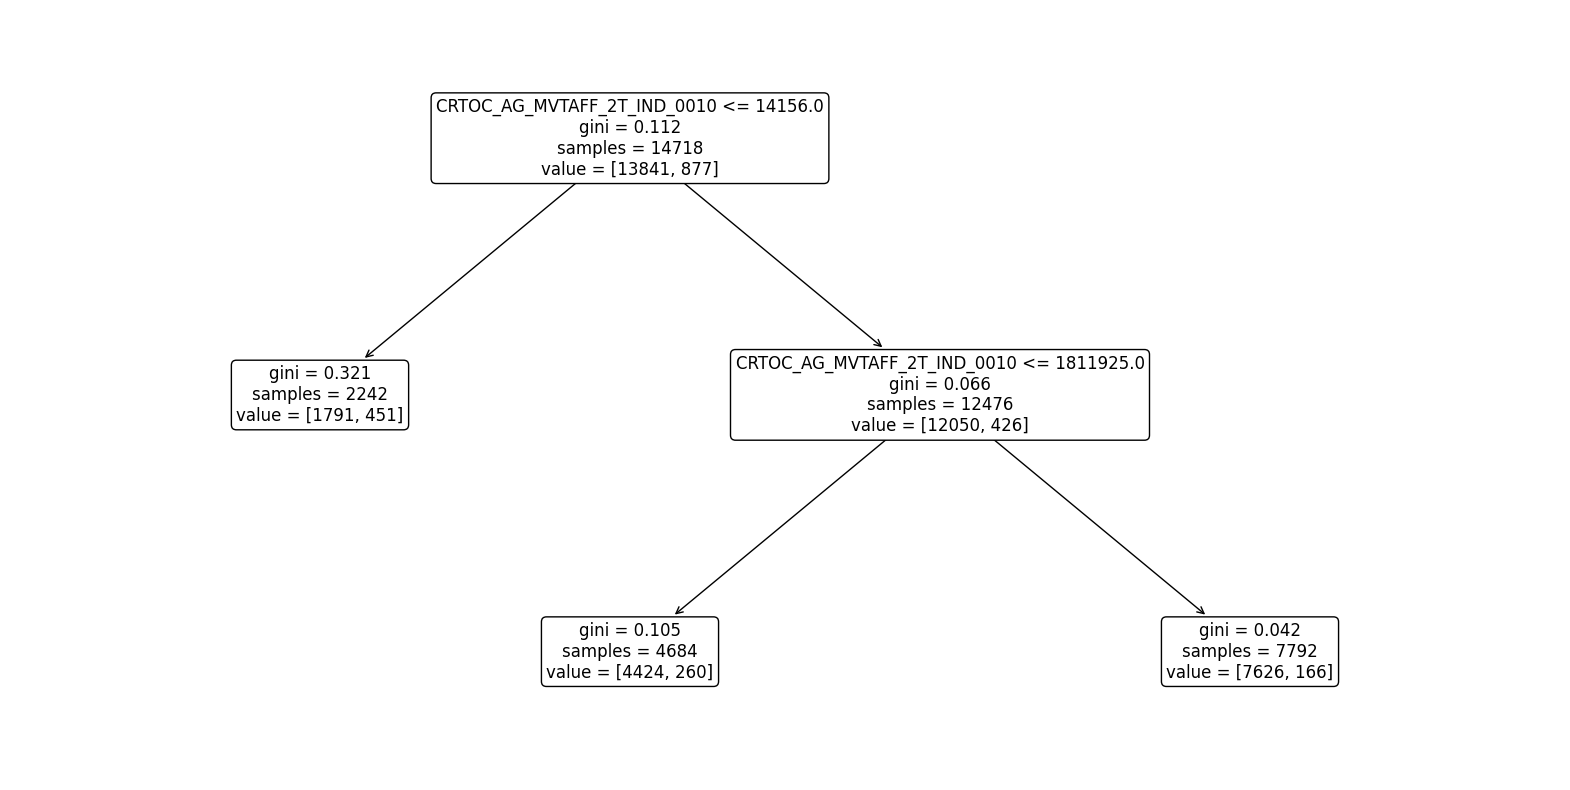

Seuils de coupure pour 'CRTOC_AG_MVTAFF_2T_IND_0010' : [-403500]


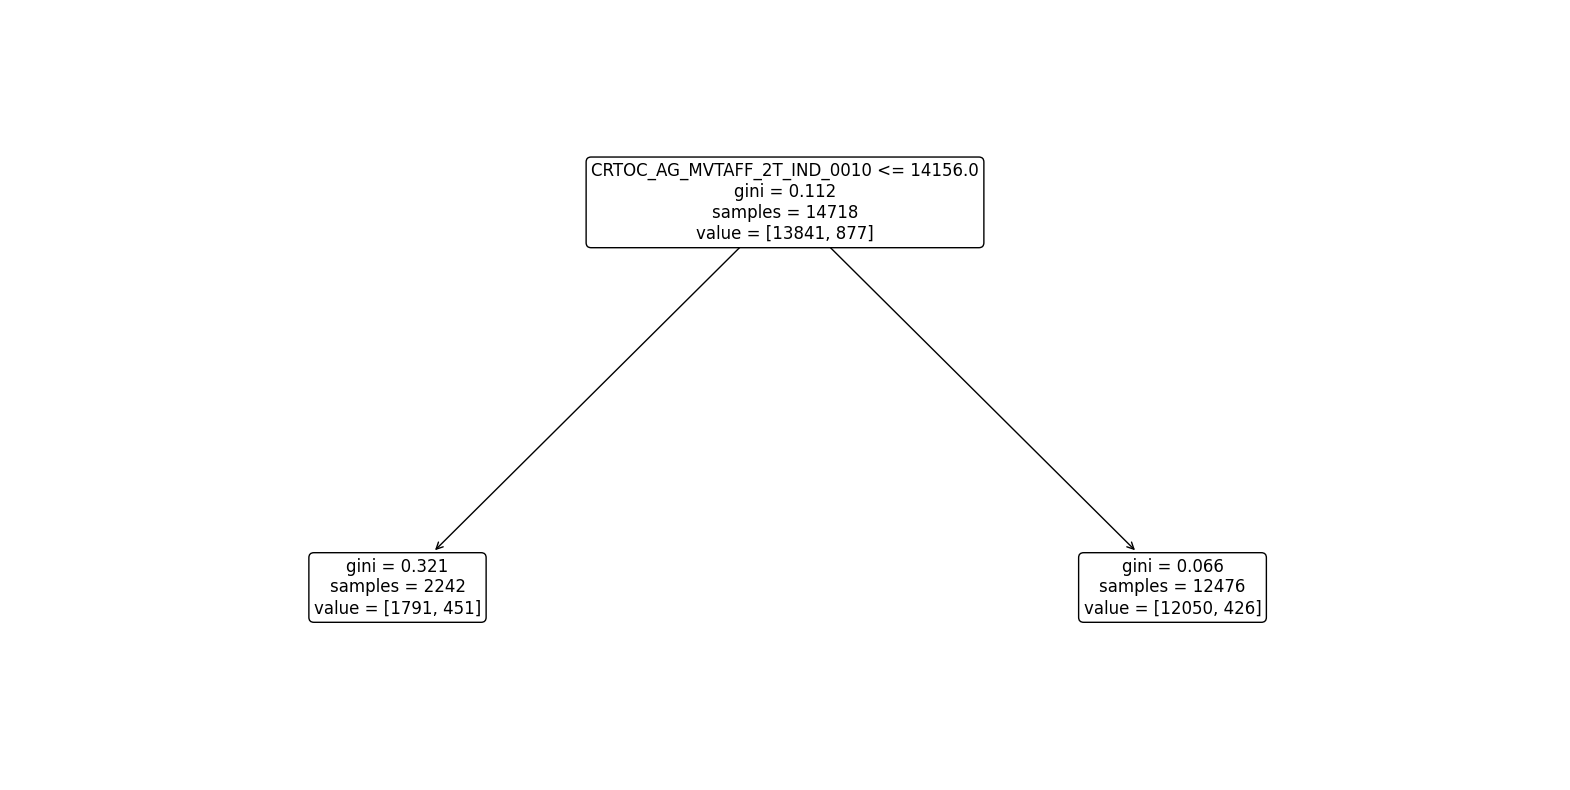

In [34]:
# Arrondir les seuils:

# Seuils de coupure pour 'ratio_jours_debiteurs' : [0.14776674]
discretized_column_name = discretize_feature_based_on_tree(
    feature='ratio_jours_debiteurs',
    n_bins=2,
    custom_thresholds=[0.15]
)

# Seuils de coupure pour 'CRTOC_AG_MVTAFF_2T_IND_0010' : [  14156. 1811925.]
discretized_column_name = discretize_feature_based_on_tree(
    feature='CRTOC_AG_MVTAFF_2T_IND_0010',
    n_bins=3,
    custom_thresholds=[14200, 1812000]
)

# Seuils de coupure pour 'CRTOC_MOY_MVTAFF_IND_0010' : [4.950000e+01 1.527275e+05]
discretized_column_name = discretize_feature_based_on_tree(
    feature='CRTOC_AG_MVTAFF_2T_IND_0010',
    n_bins=3,
    custom_thresholds=[4.95e+01, 1.527e+05]
)

#Seuils de coupure pour 'CRTOC_AG_LIGDEB_2T_IND_0015' : [-403533.5]
discretized_column_name = discretize_feature_based_on_tree(
    feature='CRTOC_AG_MVTAFF_2T_IND_0010',
    n_bins=2,
    custom_thresholds=[-403500]
)


In [5]:
sample.columns

Index(['id_client', 'DDefaut_NDB', 'datdelhis', 'AGEPRS', 'ANCIENNETE', 'CODETAJUR', 'CODITDBDF_PRO', 'CODNAF2', 'CRTAD_AG_MVTAFF_IND_0010', 'CRTAD_AG_NBECR_A', 'CRTAD_AG_NBECR_B', 'CRTAD_AG_NBJDE_BA', 'CRTAD_AG_NBJDE_BB', 'CRTAD_AG_NBJDE_BC', 'CRTAD_AG_SOLDE_IND_0009', 'CRTAD_AG_SOLDE_T', 'CRTAD_AG_SOLDE_T1', 'CRTAD_AG_SOLDE_T2', 'CRTAD_AG_SOLDE_T3', 'CRTAD_AG_SOLDE_T4', 'CRTAD_IND_0015', 'CRTAD_IND_0038', 'CRTAD_IND_0062', 'CRTAD_IND_0205', 'CRTAE_AG_SLDEPA', 'CRTAR_IND_0036', 'CRTOC_AG_LIGCRE_2T_IND_0009', 'CRTOC_AG_LIGCRE_IND_0009', 'CRTOC_AG_LIGDEB_2T_IND_0015', 'CRTOC_AG_LIGDEB_IND_0015', 'CRTOC_AG_MVTAFF_2T_IND_0010', 'CRTOC_AG_MVTAFF_IND_0010', 'CRTOC_AG_NBJCRE_2T_IND_0009', 'CRTOC_AG_NBJDEB_2T_IND_0015', 'CRTOC_AG_NBJDEB_IND_0015', 'CRTOC_IND_0010', 'CRTOC_IND_0015', 'CRTOC_IND_0164', 'CRTOC_IND_0301', 'CRTOC_MOY_MVTAFF_IND_0010', 'CRTOC_SLD_MOY', 'CRTOD_CMT_IND_0036', 'MINSOLDE_PAR', 'NBECR_PAR', 'CRTAD_IND_0042', 'CODACVPRO', 'DATCREPRSENT', 'ratio_debiteurs_3mois',
       '

In [6]:
quanti_discretized_sample = sample[['id_client', 'datdelhis', 'CRTOC_AG_MVTAFF_2T_IND_0010_discretized','ratio_jours_debiteurs_discretized', 'CRTOC_AG_NBJCRE_2T_IND_0009_discretized', 'CRTOC_IND_0164_discretized', 'CRTOC_AG_LIGDEB_2T_IND_0015_discretized', 'CRTOC_IND_0015_discretized','CRTOC_MOY_MVTAFF_IND_0010_discretized']]
quanti_discretized_sample = quanti_discretized_sample.rename(columns={'CRTOC_AG_MVTAFF_2T_IND_0010_discretized': 'CRTOC_AG_MVTAFF_2T_IND_0010', 
                                                                      'ratio_jours_debiteurs_discretized': 'ratio_jours_debiteurs',
                                                                      'CRTOC_AG_NBJCRE_2T_IND_0009_discretized': 'CRTOC_AG_NBJCRE_2T_IND_0009', 
                                                                      'CRTOC_IND_0164_discretized':'CRTOC_IND_0164', 
                                                                      'CRTOC_AG_LIGDEB_2T_IND_0015_discretized':'CRTOC_AG_LIGDEB_2T_IND_0015', 
                                                                      'CRTOC_IND_0015_discretized':'CRTOC_IND_0015',
                                                                      'CRTOC_MOY_MVTAFF_IND_0010_discretized':'CRTOC_MOY_MVTAFF_IND_0010'})
quanti_discretized_sample.head(20)

,id_client,datdelhis,CRTOC_AG_MVTAFF_2T_IND_0010,ratio_jours_debiteurs,CRTOC_AG_NBJCRE_2T_IND_0009,CRTOC_IND_0164,CRTOC_AG_LIGDEB_2T_IND_0015,CRTOC_IND_0015,CRTOC_MOY_MVTAFF_IND_0010
0,6002959649,5,3,1,2,2,2,1,3
1,3235248704,1,2,1,2,2,2,1,3
2,7995781136,3,2,1,2,2,2,1,3
3,2112452922,5,3,1,2,2,2,1,3
4,3540500580,2,3,1,2,2,2,1,3
5,8390775990,6,3,1,2,2,2,1,3
6,1528496440,3,1,1,2,2,2,1,1
7,3019876475,2,3,1,2,2,2,1,3
8,1500330744,3,3,1,2,2,1,1,3
9,3549117482,2,3,1,2,2,2,1,3


In [7]:
quanti_discretized_sample.to_excel('../data/quanti_discretized_sample.xlsx', index=False)